In [1]:
import pandas as pd
import numpy as np
from plotnine import *

%matplotlib inline

In [2]:
data = pd.read_csv("../../data/processed/expensas_full_processed_lag_3.csv",
                  dtype = {
                                "expensa_id": "object",
                                "unidad_id": "object",
                                "consorcio_id": "object",
                                "expensa_mes":"object",
                            },
                  parse_dates = ["expensa_fecha", "expensa_mes_pago", "expensa_mes_pago_anterior"])

In [3]:
data.shape

(193050, 21)

In [35]:
data.columns

Index(['expensa_id', 'consorcio_id', 'consorcio_nombre',
       'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
       'consorcio_prop_efectivo', 'unidad_id', 'unidad_denominacion',
       'unidad_tipo', 'unidad_prop_impagos', 'expensa_proporcion',
       'expensa_interes_primer_vencimiento',
       'expensa_ineteres_segundo_vencimiento', 'expensa_mes', 'expensa_fecha',
       'expensa_mes_pago', 'expensa_mes_pago_anterior', 'pago_metodo_lag_1',
       'pago_metodo_lag_2', 'pago_metodo_lag_3', 'target'],
      dtype='object')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(

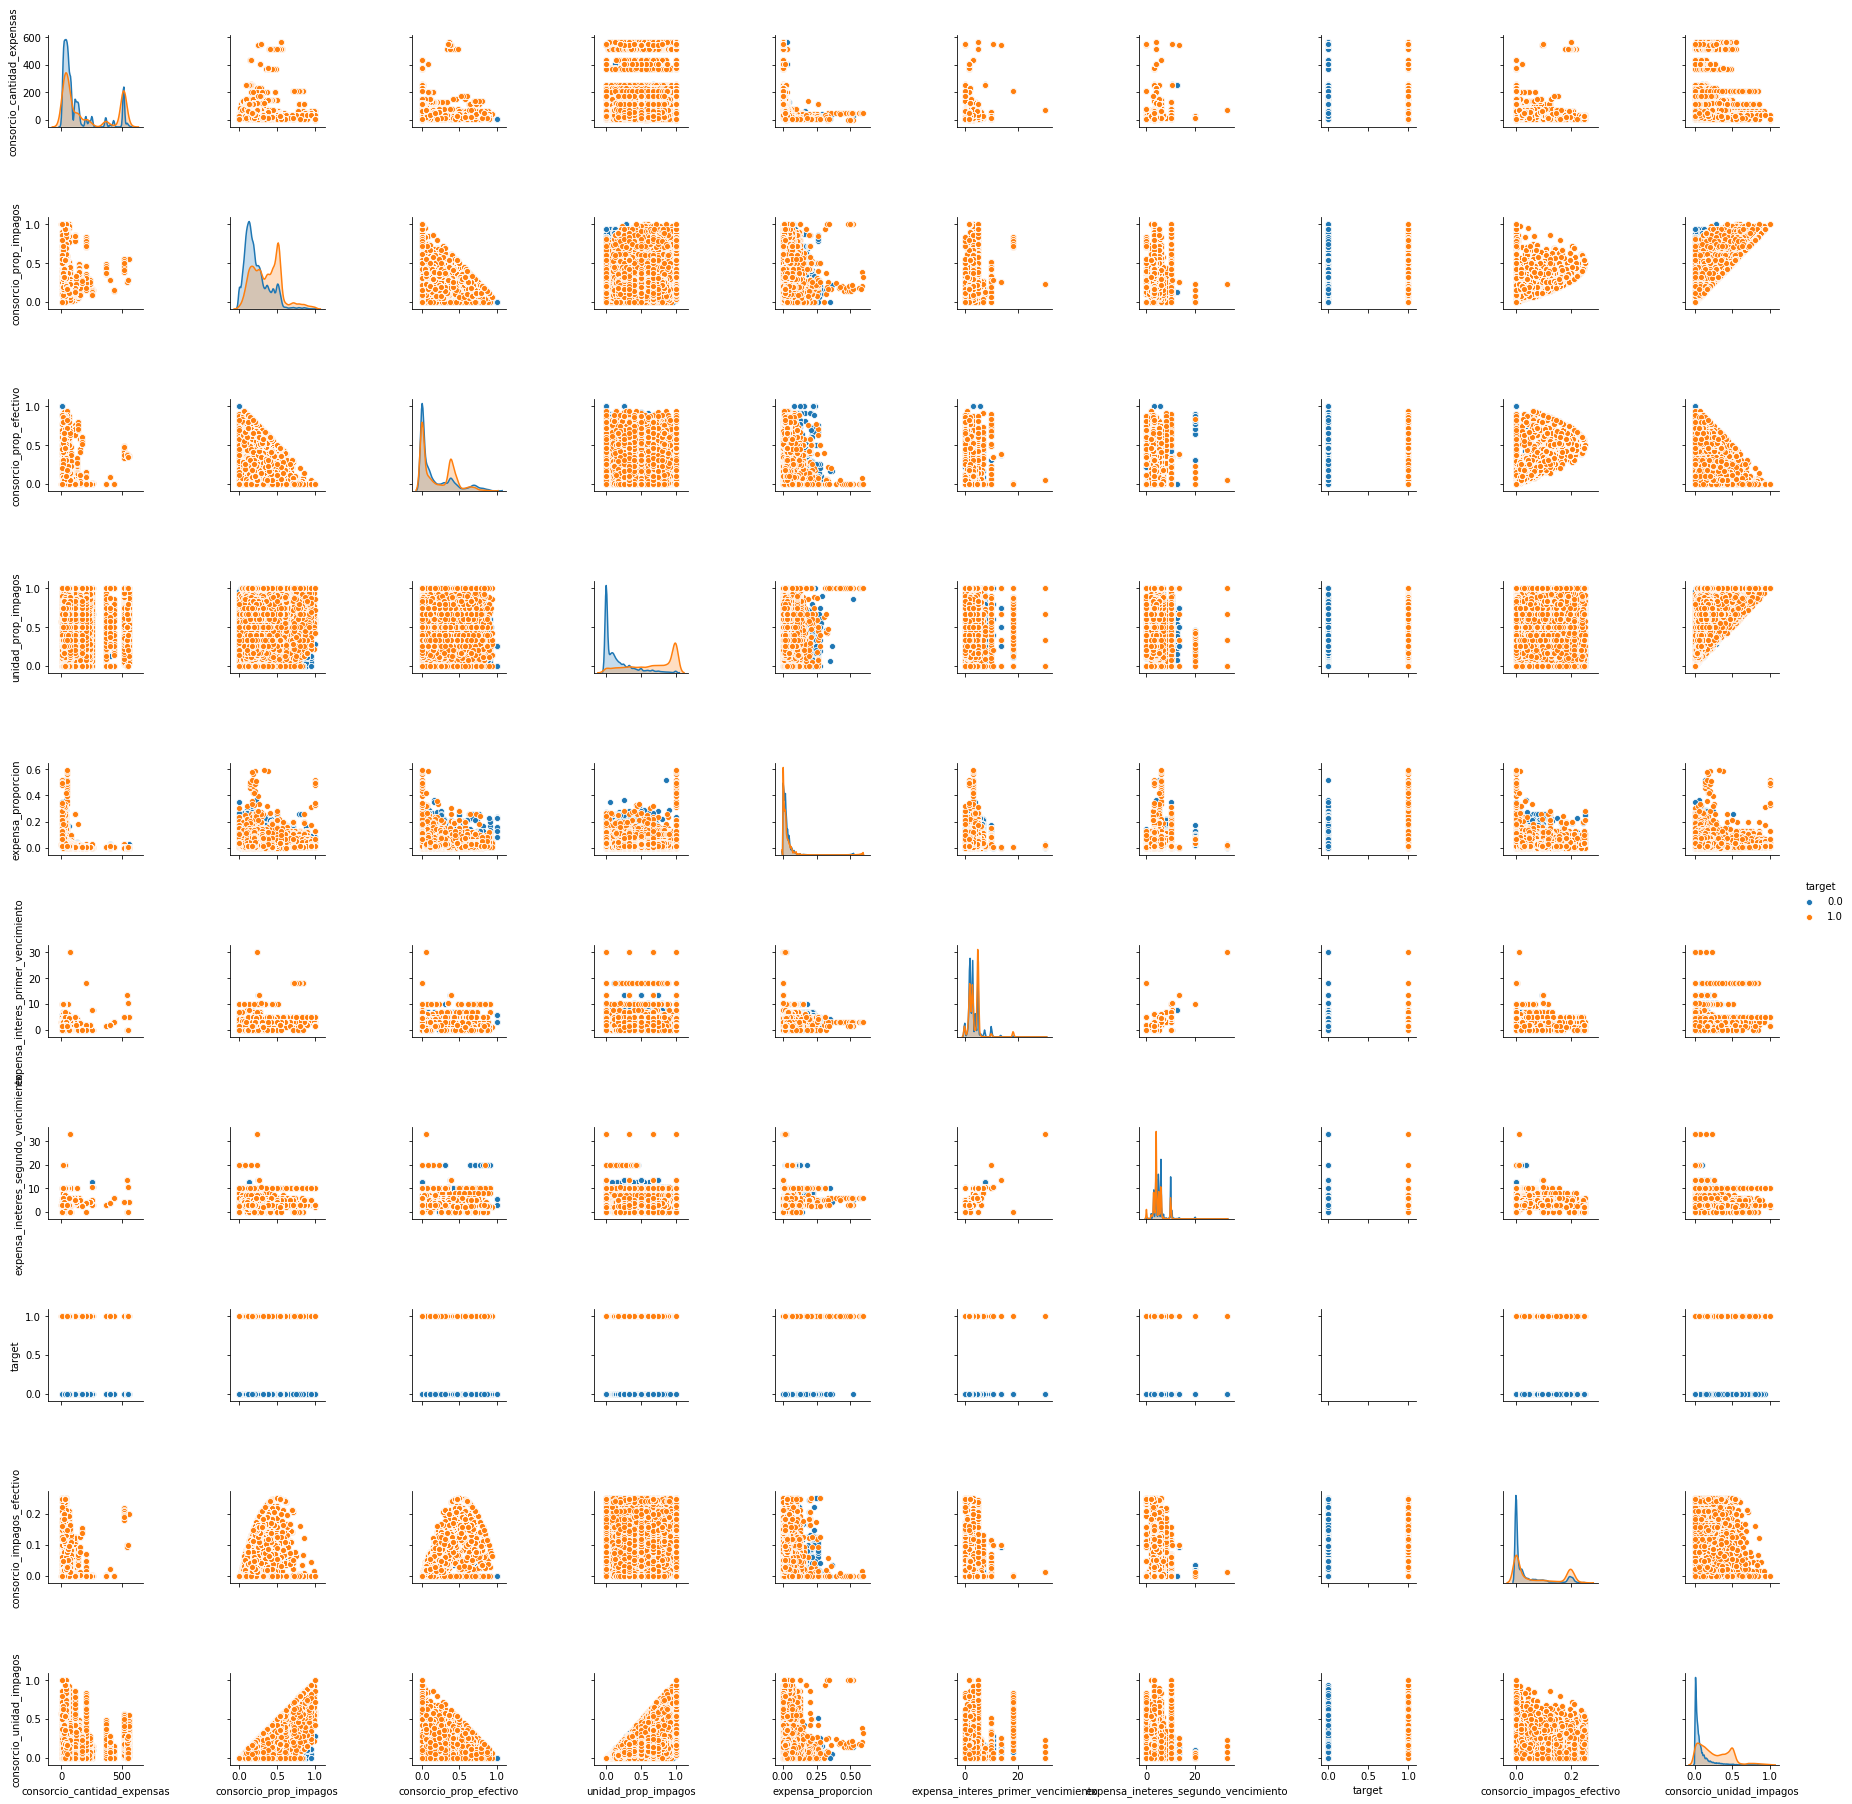

In [36]:
import seaborn as sns
data_plot = data[['consorcio_cantidad_expensas', 'consorcio_prop_impagos',
       'consorcio_prop_efectivo', 'unidad_prop_impagos', 'expensa_proporcion',
       'expensa_interes_primer_vencimiento',
       'expensa_ineteres_segundo_vencimiento','target']]

data_plot["consorcio_impagos_efectivo"] = data_plot.consorcio_prop_efectivo*data_plot.consorcio_prop_impagos
data_plot["consorcio_unidad_impagos"] = data_plot.consorcio_prop_impagos*data_plot.unidad_prop_impagos

sns.pairplot(data_plot, hue="target")

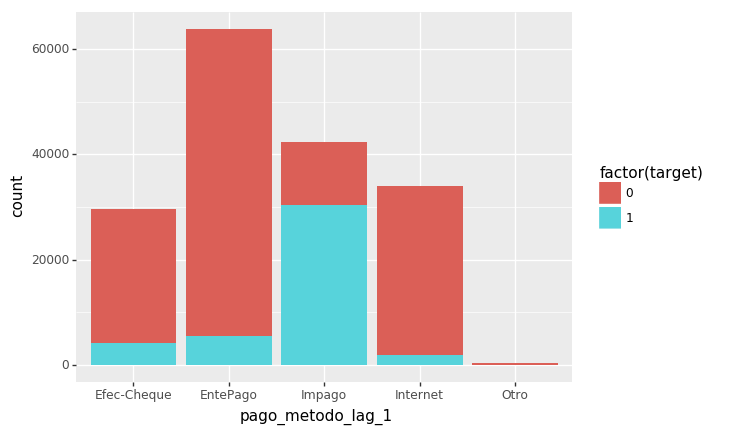

<ggplot: (-9223371952271893609)>

In [24]:
(ggplot(data)
+ geom_bar(aes(x="pago_metodo_lag_1", fill = "factor(target)")))

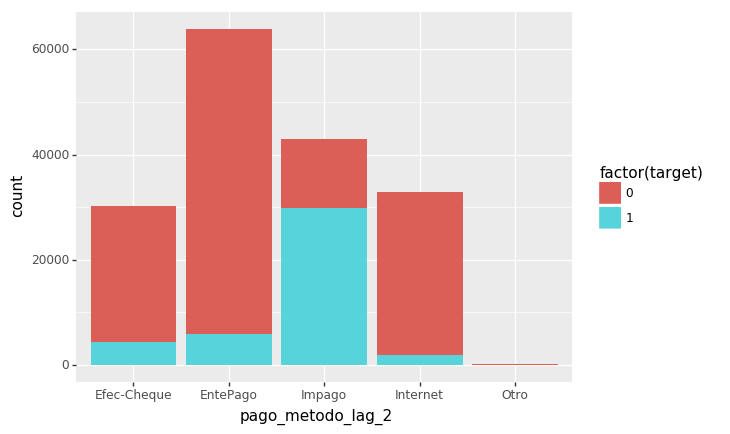

<ggplot: (-9223371952271873101)>

In [25]:
(ggplot(data)
+ geom_bar(aes(x="pago_metodo_lag_2", fill = "factor(target)")))

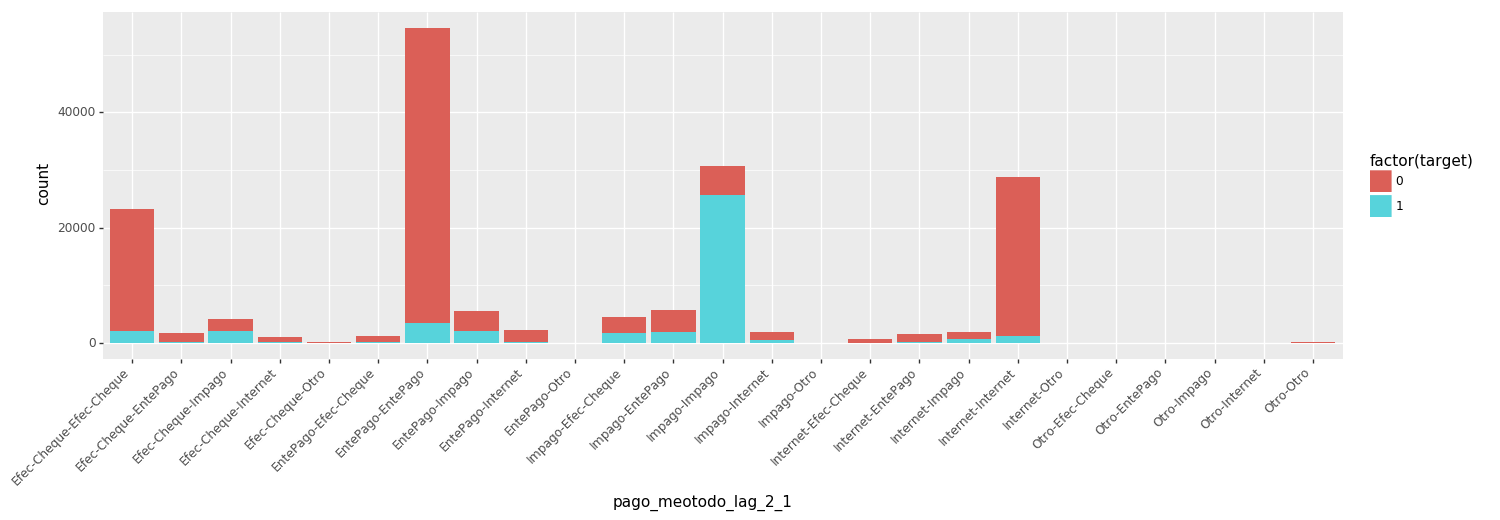

<ggplot: (84582902774)>

In [28]:
data_aux2 = data
data_aux2["pago_meotodo_lag_2_1"] = data_aux2.pago_metodo_lag_2 + '-' + data_aux2.pago_metodo_lag_1
(ggplot(data_aux2)
+ geom_bar(aes(x="pago_meotodo_lag_2_1", fill = "factor(target)"))
+ theme( axis_text_x = element_text(angle = 45, hjust = 1),
          figure_size = (16, 4.5)))

## Train-CV-Test Split Explanation

In [4]:
aux_df = data
aux_df = aux_df.sort_values("expensa_mes_pago").reset_index()

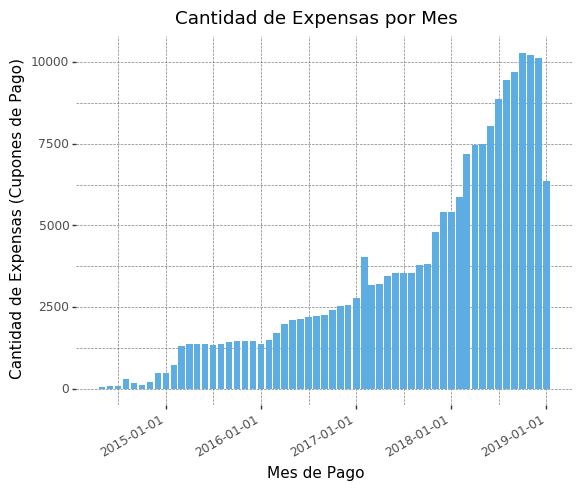

<ggplot: (-9223371945049838904)>

In [5]:
(ggplot(data=aux_df)
 + geom_bar(aes(x="expensa_mes_pago"), fill="#5DADE2")
 + theme(
     panel_background = element_rect(fill = "white"),
     panel_grid = element_line(color="grey", linetype="dashed", size=0.5),
     axis_text_x = element_text(angle = 30, hjust = 1)
 )
 + ylab("Cantidad de Expensas (Cupones de Pago)")
 + ggtitle("Cantidad de Expensas por Mes")
 + xlab("Mes de Pago")
)

In [6]:
test_size = round(len(aux_df) * 0.2)
cv_size = round(len(aux_df)*0.8*0.2)

In [7]:
from sklearn.model_selection import train_test_split
min_test_id = (aux_df.expensa_mes_pago < "2018-01-01").sum()
idxs = range(min_test_id, len(aux_df))
idx_train_cv, idx_test = train_test_split(idxs, shuffle = True, test_size =test_size)
idx_train, idx_cv = train_test_split(idx_train_cv, shuffle = True, test_size =cv_size)
idx_train += range(0, min_test_id)

In [8]:
aux_df["group"] = "0"
aux_df.loc[idx_train, "group"] = "train"
aux_df.loc[idx_cv, "group"] = "cv"
aux_df.loc[idx_test,"group"] = "test"

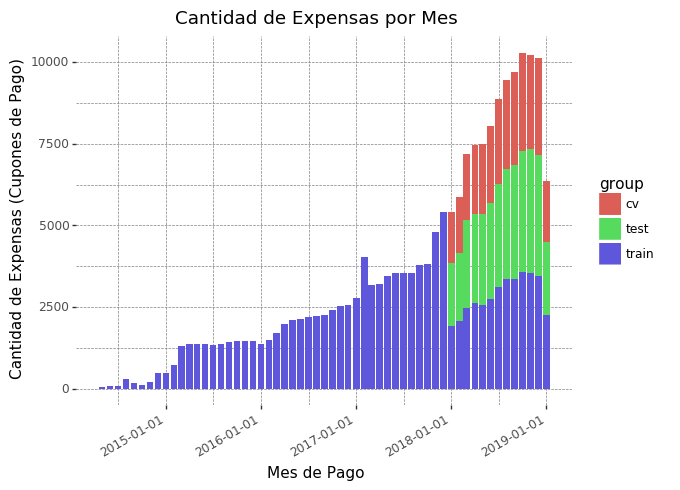

<ggplot: (-9223371945046892372)>

In [9]:
(ggplot(data=aux_df)
 + geom_bar(aes(x="expensa_mes_pago", fill="group"))
 + theme(
     panel_background = element_rect(fill = "white"),
     panel_grid = element_line(color="grey", linetype="dashed", size=0.5),
     axis_text_x = element_text(angle = 30, hjust = 1)
 )
 + ylab("Cantidad de Expensas (Cupones de Pago)")
 + ggtitle("Cantidad de Expensas por Mes")
 + xlab("Mes de Pago")
)

### Split

In [26]:
data = data.sort_values("expensa_mes_pago").reset_index().drop(columns="index")

In [27]:
X_columns  = [ 'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
               'consorcio_prop_efectivo',
               'unidad_tipo', 'unidad_prop_impagos', 
               'expensa_proporcion',
               'expensa_interes_primer_vencimiento',
               'expensa_ineteres_segundo_vencimiento', 'expensa_mes',
               'pago_metodo_lag_1', 'pago_metodo_lag_2', 'pago_metodo_lag_3']

In [28]:
min_test_id = (data.expensa_mes_pago < "2018-01-01").sum()
idxs = range(min_test_id, len(data))
idx_train_cv, idx_test = train_test_split(idxs, shuffle = True, test_size =test_size)
idx_train_cv += range(0, min_test_id)

In [29]:
idxs_train_cv2 = range(min_test_id, len(idx_train_cv))
idx_train, idx_cv = train_test_split(idxs_train_cv2, shuffle = True, test_size =cv_size)
idx_train += range(0, min_test_id)

In [30]:
X_train_cv = data.loc[idx_train_cv, X_columns + ["expensa_mes_pago"]].sort_values("expensa_mes_pago").reset_index().drop(columns=["index", "expensa_mes_pago"])
Y_train_cv = data.loc[idx_train_cv, ["target","expensa_mes_pago"]].sort_values("expensa_mes_pago").reset_index().drop(columns=["index", "expensa_mes_pago"])
X_test = data.loc[idx_test,X_columns]
Y_test = data.loc[idx_test, ["target"]]

## Dummies y Scaler

In [25]:
X_train_cv = pd.get_dummies(X_train_cv)
X_test = pd.get_dummies(X_test)

In [16]:
delete_columns = [column for column in X_test.columns if column not in X_train_cv.columns]
X_test = X_test.drop(columns = delete_columns)

In [17]:
print(X_train_cv.shape)
print(X_test.shape)

(154440, 42)
(38610, 42)


In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_cv[["consorcio_cantidad_expensas"]])
X_train_cv.consorcio_cantidad_expensas = scaler.transform(X_train_cv[["consorcio_cantidad_expensas"]])
X_test.consorcio_cantidad_expensas = scaler.transform(X_test[["consorcio_cantidad_expensas"]])

## Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegressionCV

linear_modelCV = LogisticRegressionCV(
    cv = [(idx_train, idx_cv)],
    scoring = "f1",
    n_jobs = -1,
    verbose = 5,
    refit = True,
)

In [73]:
linear_modelCV.fit(X_train_cv, Y_train_cv)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None,
           cv=[([76678, 79066, 103730, 107149, 88704, 124242, 96367, 130303, 116174, 121332, 94089, 118435, 77717, 85640, 65892, 115302, 116898, 71675, 116810, 114184, 109030, 78501, 69268, 117641, 102828, 131857, 66403, 103987, 131630, 124723, 79336, 64690, 91227, 70369, 125399, 104087, 74617, 83525, 79701, 1...985, 110001, 111461, 109066, 135906, 114858, 124704, 69911, 63619, 112161, 130607, 103310, 101813])],
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='f1', solver='lbfgs',
           tol=0.0001, verbose=5)

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
train_preds = linear_modelCV.predict(X_train_cv)
print("accuracy:", accuracy_score(Y_train_cv, train_preds))
print("precision:", precision_score(Y_train_cv, train_preds))
print("recall:", recall_score(Y_train_cv, train_preds))
print("f1:", f1_score(Y_train_cv, train_preds))
print("--------------------------------------------------")
test_preds = linear_modelCV.predict(X_test)
print("accuracy:", accuracy_score(Y_test, test_preds))
print("precision:", precision_score(Y_test, test_preds))
print("recall:", recall_score(Y_test, test_preds))
print("f1:", f1_score(Y_test, test_preds))

accuracy: 0.8759783926799691
precision: 0.792441939426864
recall: 0.6844080818744318
f1: 0.7344735889729832
--------------------------------------------------
accuracy: 0.879233301975541
precision: 0.7830903790087463
recall: 0.6721721721721722
f1: 0.7234042553191489


In [75]:
import pickle
with open('../../models/logisticRegression2.pkl', 'wb') as file:
    pickle.dump(linear_modelCV, file)
with open('../../models/minmaxScaler2.pkl', 'wb') as file:
    pickle.dump(scaler, file)
with open('../../models/columns_list2.pkl', 'wb') as file:
    pickle.dump(X_train_cv.columns, file)

## Analisis de Coeficientes

In [25]:
lm_coef = pd.DataFrame({
    "variable": X_train_cv.columns,
    "coef": linear_modelCV.coef_[0]
})

In [26]:
lm_coef["abs_coef"] = abs(lm_coef.coef)

In [27]:
from pandas.api.types import CategoricalDtype
lm_coef = lm_coef.sort_values("abs_coef", ascending = False)
lm_coef = lm_coef.reset_index().drop(columns="index")

variable_cat = CategoricalDtype(categories=lm_coef.variable, ordered=True)
lm_coef.variable = lm_coef.variable.astype(variable_cat)

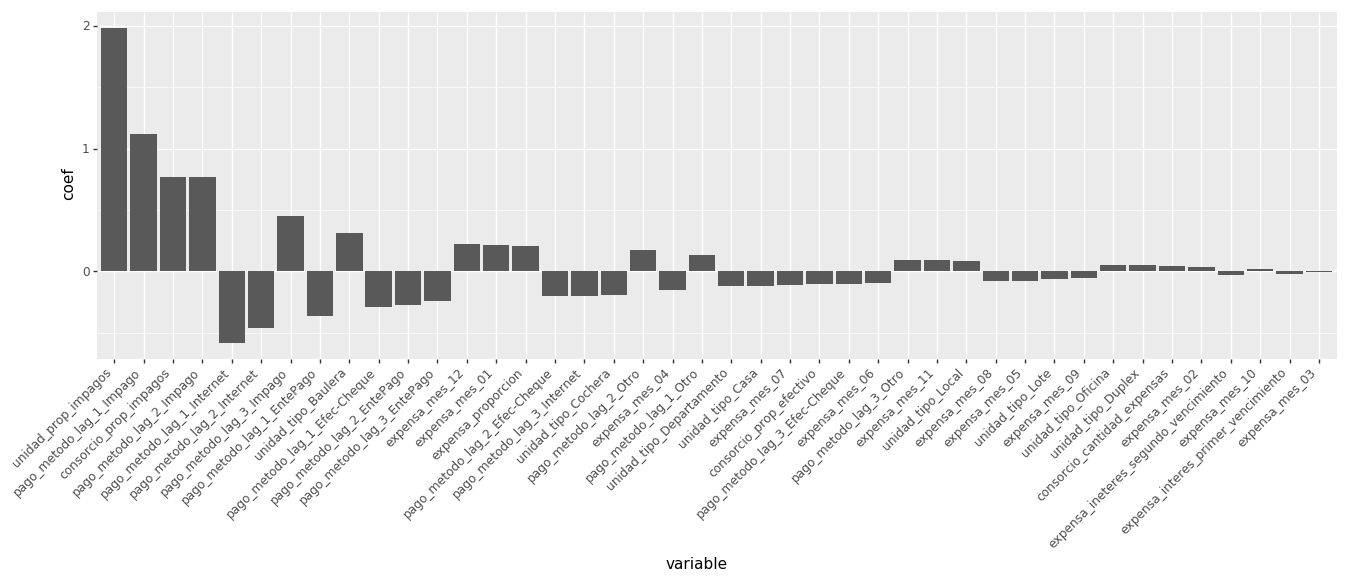

<ggplot: (-9223371878767937192)>

In [28]:
figure_size = (16, 4.8)
(ggplot(data=lm_coef)
+ geom_bar(aes(x = "variable",y="coef"), stat = "identity")
+ theme( axis_text_x = element_text(angle = 45, hjust = 1),
          figure_size = (16, 4.5))
)

### Analisis de errores

In [33]:
data_test = data.loc[idx_test,:]
data_test["predicted"] = test_preds
data_test_por_consorcio = data_test[["consorcio_id", "consorcio_nombre", "target", "predicted"]]
data_test_por_consorcio["TP"] = data_test_por_consorcio.target.map(bool) & data_test_por_consorcio.predicted.map(bool)
data_test_por_consorcio["TN"] = ~data_test_por_consorcio.target.map(bool) & ~data_test_por_consorcio.predicted.map(bool)
data_test_por_consorcio["FP"] = ~data_test_por_consorcio.target.map(bool) & data_test_por_consorcio.predicted.map(bool)
data_test_por_consorcio["FN"] = data_test_por_consorcio.target.map(bool) & ~data_test_por_consorcio.predicted.map(bool)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

In [34]:
data_test_por_consorcio = data_test_por_consorcio.groupby(["consorcio_id","consorcio_nombre"]).sum()

In [35]:
data_test_por_consorcio["Total"] = data_test_por_consorcio.TP + data_test_por_consorcio.TN + data_test_por_consorcio.FP + data_test_por_consorcio.FN
data_test_por_consorcio["PP"] = data_test_por_consorcio.TP + data_test_por_consorcio.FP
data_test_por_consorcio["PN"] = data_test_por_consorcio.TN + data_test_por_consorcio.FN
data_test_por_consorcio["RP"] = data_test_por_consorcio.TP + data_test_por_consorcio.FN
data_test_por_consorcio["RN"] = data_test_por_consorcio.FP + data_test_por_consorcio.TN
data_test_por_consorcio["accuracy"] = (data_test_por_consorcio.TP + data_test_por_consorcio.TN)/data_test_por_consorcio.Total
data_test_por_consorcio["precision"] = (data_test_por_consorcio.TP)/data_test_por_consorcio.PP
data_test_por_consorcio["recall"] = data_test_por_consorcio.TP / data_test_por_consorcio.RP

In [36]:
data_test_por_consorcio[["TP","TN","FP","FN", "Total","accuracy", "precision", "recall"]].sort_values("accuracy", ascending = True)

,,TP,TN,FP,FN,Total,accuracy,precision,recall
consorcio_id,consorcio_nombre,,,,,,,,
1884,CONSORCIO DE PROPIETARIOS BARRIO PRIVADO VALLE PARRAL,3.0,1.0,0.0,6.0,10.0,0.400000,1.000000,0.333333
1850,CONSORCIO CENTRAL,0.0,1.0,1.0,0.0,2.0,0.500000,0.000000,NaN
1445,EL NOGAL,11.0,14.0,8.0,7.0,40.0,0.625000,0.578947,0.611111
1490,"CONSORCIO MONOBLOCK A""""",52.0,84.0,26.0,49.0,211.0,0.644550,0.666667,0.514851
1852,CONSORCIO EUROPA IX,1.0,1.0,1.0,0.0,3.0,0.666667,0.500000,1.000000
1530,EDIFICIO SAFIRA III,28.0,14.0,11.0,9.0,62.0,0.677419,0.717949,0.756757
1591,CONSORCIO BAIGORRI 947 EXT.,18.0,39.0,12.0,15.0,84.0,0.678571,0.600000,0.545455
1723,Consorcio Monoblock I,7.0,25.0,5.0,10.0,47.0,0.680851,0.583333,0.411765
1699,MANZANOS I,13.0,34.0,9.0,12.0,68.0,0.691176,0.590909,0.520000


In [48]:
data_test_por_consorcio.accuracy.mean()

0.8662344158979725

In [47]:
data.loc[(data.consorcio_id == "1464") & (data.expensa_mes_pago >= '2018-01-01')
         ,[ 'unidad_id', 'unidad_denominacion', 'expensa_mes_pago',
                                       'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
                                       'consorcio_prop_efectivo',
                                       'unidad_tipo', 'unidad_prop_impagos', 
                                       'expensa_proporcion',
                                       'expensa_interes_primer_vencimiento',
                                       'expensa_ineteres_segundo_vencimiento', 'expensa_mes',
                                       'pago_metodo_lag_3','pago_metodo_lag_2','pago_metodo_lag_1', 
                                       'target']].sort_values(["expensa_mes_pago", "unidad_id"])

,unidad_id,unidad_denominacion,expensa_mes_pago,consorcio_cantidad_expensas,consorcio_prop_impagos,consorcio_prop_efectivo,unidad_tipo,unidad_prop_impagos,expensa_proporcion,expensa_interes_primer_vencimiento,expensa_ineteres_segundo_vencimiento,expensa_mes,pago_metodo_lag_3,pago_metodo_lag_2,pago_metodo_lag_1,target
87353,25834,Pb A,2018-01-01,24.0,0.000000,0.583333,Departamento,0.050000,0.0442,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
87324,25835,Pb B,2018-01-01,24.0,0.000000,0.583333,Departamento,0.050000,0.0726,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
86908,25836,Pb C,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0368,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
87079,25837,Pb D,2018-01-01,24.0,0.000000,0.583333,Departamento,0.100000,0.0368,2.5,2.5,12,EntePago,Efec-Cheque,EntePago,0.0
87057,25838,Pb E,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0395,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
86901,25839,Pb F,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0372,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
87176,25840,Pb G,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0379,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
86654,25841,1A,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0436,2.5,2.5,12,EntePago,Efec-Cheque,Efec-Cheque,0.0
86820,25842,1B,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0454,2.5,2.5,12,EntePago,EntePago,EntePago,0.0
86721,25843,1C,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0431,2.5,2.5,12,EntePago,EntePago,EntePago,0.0


In [31]:
data_pagos_historicos = X_train_cv[["pago_metodo_lag_1", "pago_metodo_lag_2", "unidad_prop_impagos"]]
data_pagos_historicos["pago_metodo_lag_2_1"] = data_pagos_historicos.pago_metodo_lag_2 + '-' + data_pagos_historicos.pago_metodo_lag_1
data_pagos_historicos = pd.get_dummies(data_pagos_historicos[["pago_metodo_lag_1"]])
data_pagos_historicos.shape

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(154440, 5)

In [32]:
data_pagos_historicos_test = X_test[["pago_metodo_lag_1", "pago_metodo_lag_2", "unidad_prop_impagos"]]
data_pagos_historicos_test["pago_metodo_lag_2_1"] = data_pagos_historicos_test.pago_metodo_lag_2 + '-' + data_pagos_historicos_test.pago_metodo_lag_1
data_pagos_historicos_test = pd.get_dummies(data_pagos_historicos_test[["pago_metodo_lag_1"]])
data_pagos_historicos_test.shape

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(38610, 5)

In [33]:
for column in [column for column in data_pagos_historicos.columns if column not in data_pagos_historicos_test.columns]:
    data_pagos_historicos_test[column] = 0

In [34]:

for column in [column for column in data_pagos_historicos_test.columns if column not in data_pagos_historicos.columns]:
    data_pagos_historicos_test = data_pagos_historicos_test.drop(columns= column)

In [35]:
data_pagos_historicos_test.shape

(38610, 5)

In [36]:
from sklearn.linear_model import LogisticRegressionCV
linear_modelCV_ph = LogisticRegressionCV(
    cv = [(idx_train, idx_cv)],
    scoring = "f1",
    n_jobs = -1,
    verbose = 5,
    refit = True,
)

In [37]:
linear_modelCV_ph.fit(data_pagos_historicos, Y_train_cv)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


LogisticRegressionCV(Cs=10, class_weight=None,
           cv=[([89791, 89660, 87380, 140374, 104152, 130945, 135246, 109550, 147024, 89031, 111692, 114320, 113570, 137180, 121290, 93682, 119005, 141435, 119787, 110560, 108183, 134948, 88585, 95605, 109971, 118301, 107517, 97164, 115961, 97403, 100337, 119614, 120671, 99816, 102488, 147841, 94854, 104974, 8...37, 147380, 129667, 108621, 90359, 143663, 119983, 140773, 108706, 101790, 102487, 142299, 135781])],
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='f1', solver='lbfgs',
           tol=0.0001, verbose=5)

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
train_preds = linear_modelCV_ph.predict(data_pagos_historicos)
print("accuracy:", accuracy_score(Y_train_cv, train_preds))
print("precision:", precision_score(Y_train_cv, train_preds))
print("recall:", recall_score(Y_train_cv, train_preds))
print("f1:", f1_score(Y_train_cv, train_preds))
print("--------------------------------------------------")
test_preds = linear_modelCV_ph.predict(data_pagos_historicos_test)
print("accuracy:", accuracy_score(Y_test, test_preds))
print("precision:", precision_score(Y_test, test_preds))
print("recall:", recall_score(Y_test, test_preds))
print("f1:", f1_score(Y_test, test_preds))

accuracy: 0.8632867132867132
precision: 0.742434887946699
recall: 0.745106620954604
f1: 0.7437683551370112
--------------------------------------------------
accuracy: 0.8597772597772598
precision: 0.6984491044124072
recall: 0.7067860300618921
f1: 0.7025928367391782


In [39]:
import pickle
with open('../../models/logisticRegression_ph.pkl', 'wb') as file:
    pickle.dump(linear_modelCV_ph, file)

In [40]:
len(data_pagos_historicos.columns)

5

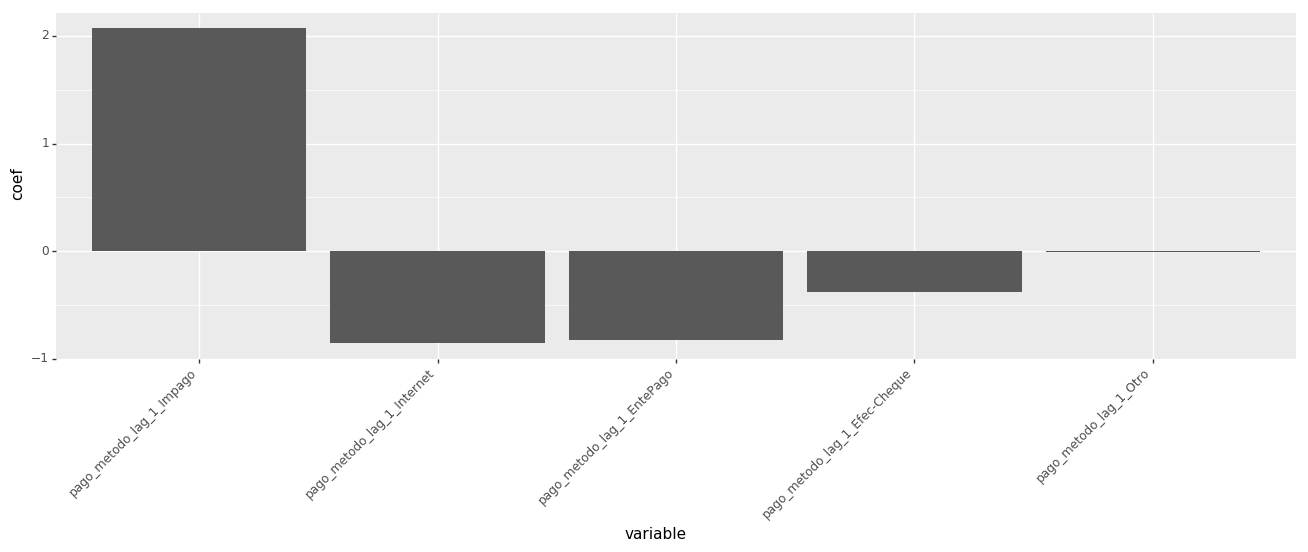

<ggplot: (91807878920)>

In [41]:
lm_coef = pd.DataFrame({
    "variable": data_pagos_historicos.columns,
    "coef": linear_modelCV_ph.coef_[0]
})

lm_coef["abs_coef"] = abs(lm_coef.coef)

from pandas.api.types import CategoricalDtype
lm_coef = lm_coef.sort_values("abs_coef", ascending = False)
lm_coef = lm_coef.reset_index().drop(columns="index")

variable_cat = CategoricalDtype(categories=lm_coef.variable, ordered=True)
lm_coef.variable = lm_coef.variable.astype(variable_cat)

figure_size = (16, 4.8)
(ggplot(data=lm_coef)
+ geom_bar(aes(x = "variable",y="coef"), stat = "identity")
+ theme( axis_text_x = element_text(angle = 45, hjust = 1),
          figure_size = (16, 4.5))
)

## Evaluacion del error

In [42]:
data_train = data.loc[idx_train_cv,:]

In [43]:
data_train["preds"] = train_preds

In [44]:
data_train["error"] = data_train.target != data_train.preds

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


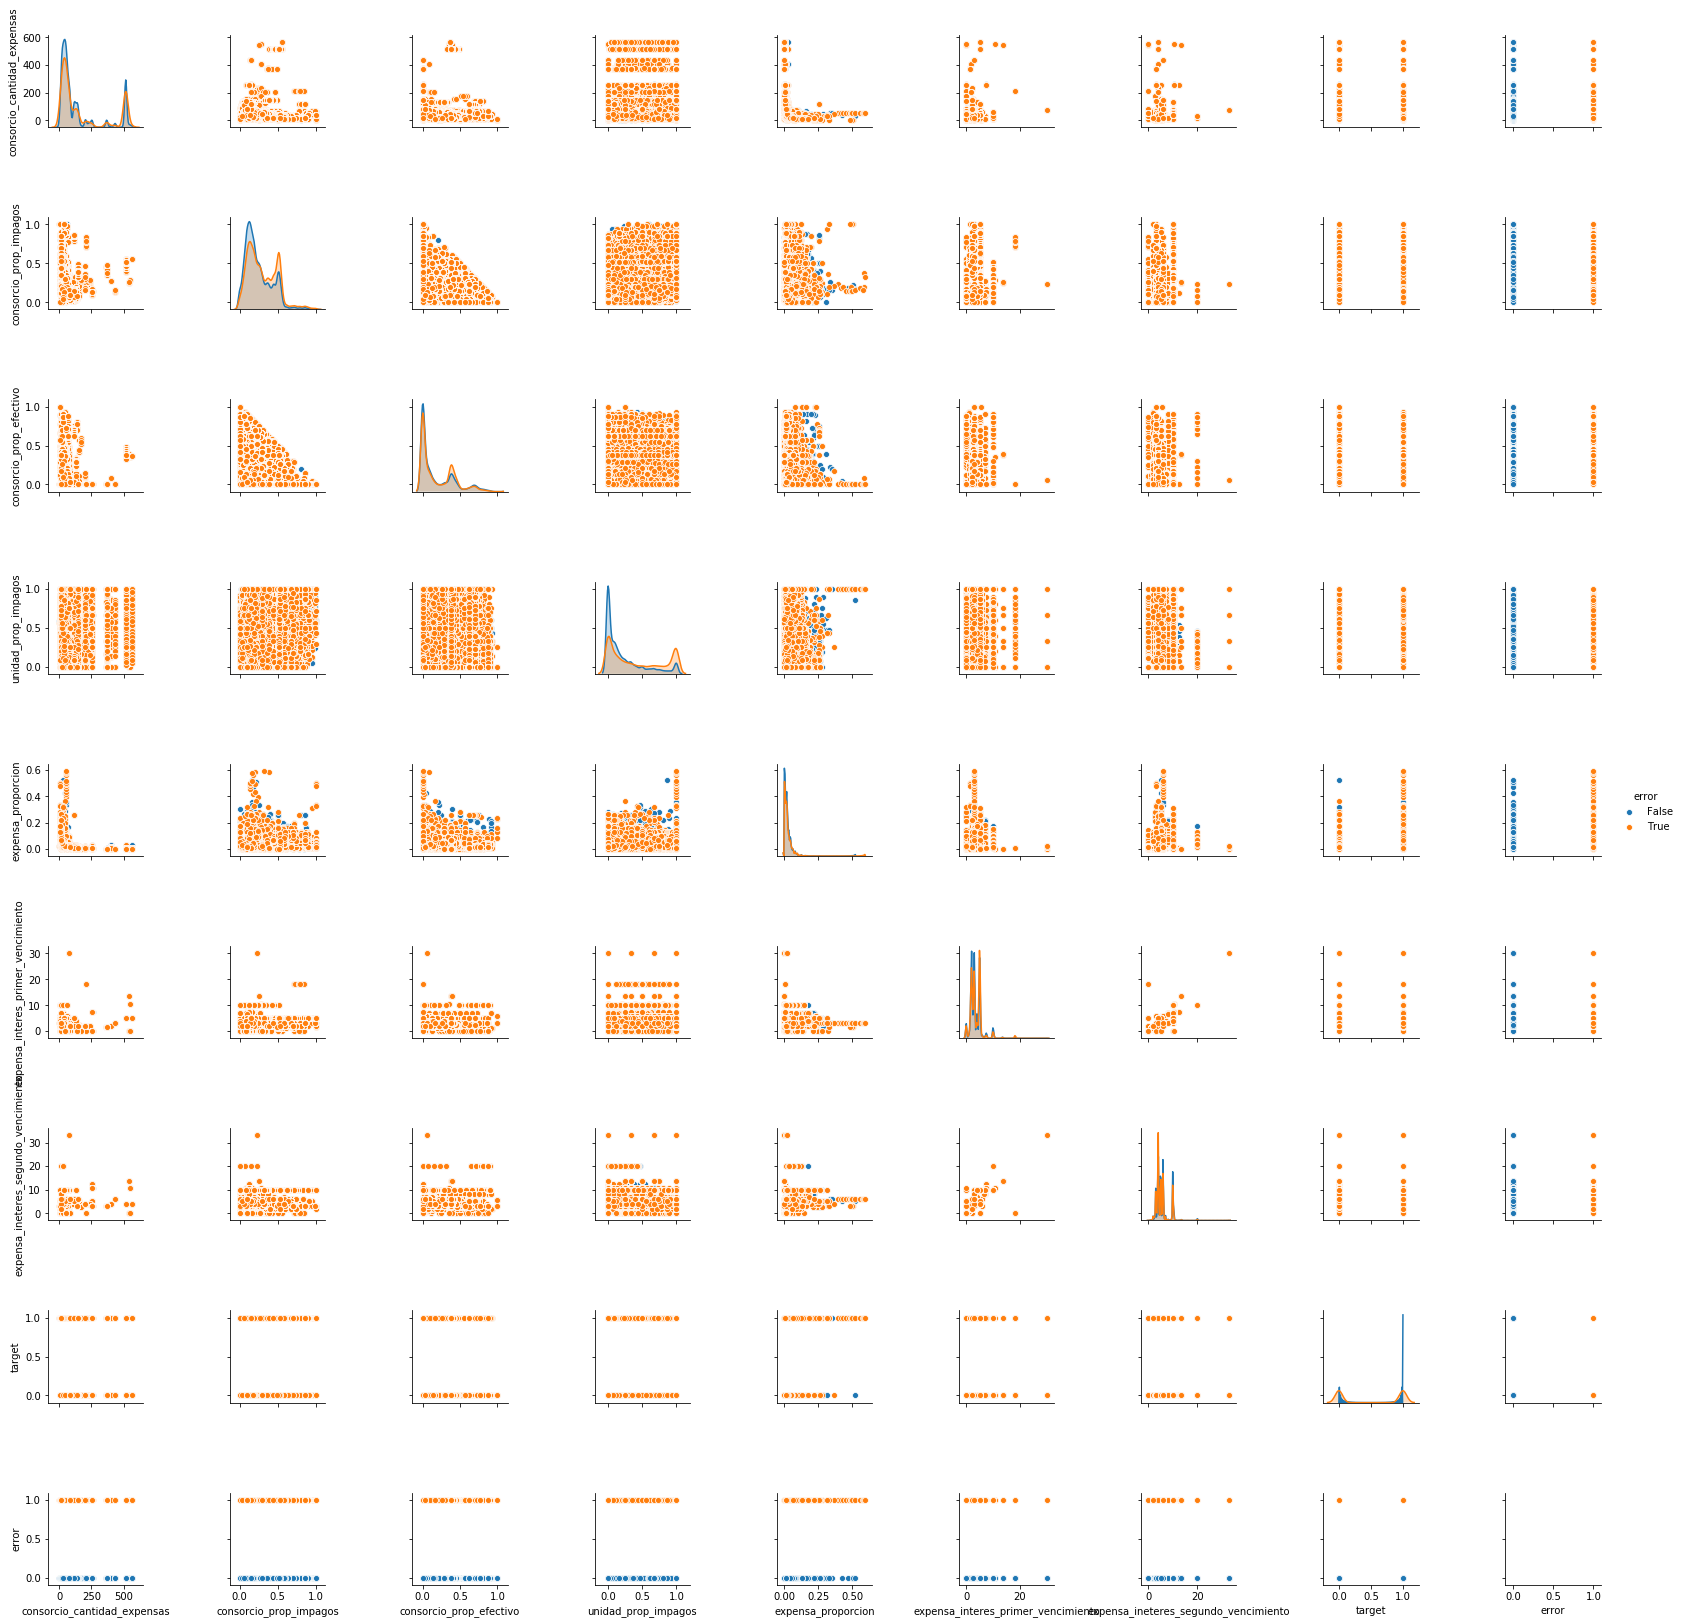

In [47]:
import seaborn as sns
sns.pairplot(data_train[['consorcio_cantidad_expensas', 'consorcio_prop_impagos',
       'consorcio_prop_efectivo', 'unidad_prop_impagos', 'expensa_proporcion',
       'expensa_interes_primer_vencimiento',
       'expensa_ineteres_segundo_vencimiento','target', 'error']], hue="error")

In [48]:
data_pagos_historicos = X_train_cv[["pago_metodo_lag_1", "consorcio_prop_impagos"]]
data_pagos_historicos = pd.get_dummies(data_pagos_historicos)
data_pagos_historicos.shape

data_pagos_historicos_test = X_test[["pago_metodo_lag_1", "consorcio_prop_impagos"]]
data_pagos_historicos_test = pd.get_dummies(data_pagos_historicos_test)
data_pagos_historicos_test.shape

(38610, 6)

In [49]:
linear_modelCV_ph.fit(data_pagos_historicos, Y_train_cv)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


LogisticRegressionCV(Cs=10, class_weight=None,
           cv=[([89791, 89660, 87380, 140374, 104152, 130945, 135246, 109550, 147024, 89031, 111692, 114320, 113570, 137180, 121290, 93682, 119005, 141435, 119787, 110560, 108183, 134948, 88585, 95605, 109971, 118301, 107517, 97164, 115961, 97403, 100337, 119614, 120671, 99816, 102488, 147841, 94854, 104974, 8...37, 147380, 129667, 108621, 90359, 143663, 119983, 140773, 108706, 101790, 102487, 142299, 135781])],
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='f1', solver='lbfgs',
           tol=0.0001, verbose=5)

In [51]:
train_preds = linear_modelCV_ph.predict(data_pagos_historicos)
print("accuracy:", accuracy_score(Y_train_cv, train_preds))
print("precision:", precision_score(Y_train_cv, train_preds))
print("recall:", recall_score(Y_train_cv, train_preds))
print("f1:", f1_score(Y_train_cv, train_preds))
print("--------------------------------------------------")
test_preds = linear_modelCV_ph.predict(data_pagos_historicos_test)
print("accuracy:", accuracy_score(Y_test, test_preds))
print("precision:", precision_score(Y_test, test_preds))
print("recall:", recall_score(Y_test, test_preds))
print("f1:", f1_score(Y_test, test_preds))

accuracy: 0.8632867132867132
precision: 0.742434887946699
recall: 0.745106620954604
f1: 0.7437683551370112
--------------------------------------------------
accuracy: 0.8597772597772598
precision: 0.6984491044124072
recall: 0.7067860300618921
f1: 0.7025928367391782
